In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
from scipy.stats import norm, lognorm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
from scipy.interpolate import CubicSpline

In [4]:
# Load data from csv file
data = pd.read_csv("data.csv")
x = data['x'].values
y = data['y'].values

[a]

In [5]:
cs_knots = np.quantile(x, [0.2,  0.8])    # can be n <> 3 knots here too, number of basis functions change

cs_basis = dmatrix('bs(x, knots = cs_knots, degree = 3, include_intercept = False)',
                   {'x': x}, return_type = 'dataframe')

cs_basis.head(3)

,Intercept,"bs(x, knots=cs_knots, degree=3, include_intercept=False)[0]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[1]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[2]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[3]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[4]"
0,1.0,0.000000,0.000000,0.000000,0.0,0.0
1,1.0,0.268471,0.007424,0.000053,0.0,0.0
2,1.0,0.467216,0.028156,0.000425,0.0,0.0


In [6]:
# estimation
m_linear = sm.OLS(y, cs_basis).fit()
# prediction and inference
m_linear_fit = m_linear.get_prediction(cs_basis).summary_frame()
type(m_linear_fit)
m_linear_fit.head(3)

pandas.core.frame.DataFrame

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.017630,0.042948,-0.068927,0.104187,-0.123506,0.158765
1,-0.000079,0.028748,-0.058017,0.057859,-0.125713,0.125555
2,-0.008705,0.021815,-0.052671,0.035260,-0.128539,0.111128


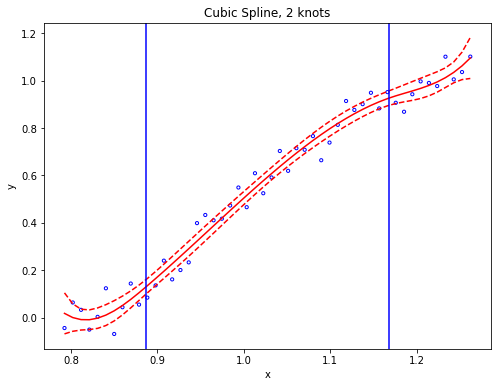

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, facecolors='none', edgecolors='b', s=10);
plt.plot(x, m_linear_fit["mean"], color = 'r');
plt.plot(x, m_linear_fit["mean_ci_lower"], color = 'r', linestyle = 'dashed');
plt.plot(x, m_linear_fit["mean_ci_upper"], color = 'r', linestyle = 'dashed');
plt.axvline(x = cs_knots[0], color = 'b');
plt.axvline(x = cs_knots[1], color = 'b');
plt.title("Cubic Spline, 2 knots");
plt.xlabel("x");
plt.ylabel("y");

[b]

In [8]:
cs_knots_b = np.quantile(x, [0, 0.25, 0.5, 0.75, 1])    # can be n <> 3 knots here too, number of basis functions change

cs_basis_b = dmatrix('bs(x, knots = cs_knots, degree = 3, include_intercept = False)',
                     {'x': x}, return_type = 'dataframe')

cs_basis_b.head(3)

,Intercept,"bs(x, knots=cs_knots, degree=3, include_intercept=False)[0]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[1]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[2]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[3]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[4]"
0,1.0,0.000000,0.000000,0.000000,0.0,0.0
1,1.0,0.268471,0.007424,0.000053,0.0,0.0
2,1.0,0.467216,0.028156,0.000425,0.0,0.0


In [9]:
c1 = cs_knots_b[0]
c2 = cs_knots_b[1]
c3 = cs_knots_b[2]
c4 = cs_knots_b[3]
c5 = cs_knots_b[4]

# create basis functions
d1 = (np.maximum(0, (x-c1)**3) - np.maximum(0, (x-c5)**3))/(c5-c1)
d2 = (np.maximum(0, (x-c2)**3) - np.maximum(0, (x-c5)**3))/(c5-c2)
d3 = (np.maximum(0, (x-c3)**3) - np.maximum(0, (x-c5)**3))/(c5-c3)
d4 = (np.maximum(0, (x-c4)**3) - np.maximum(0, (x-c5)**3))/(c5-c4)

bf1 = [1] * len(x)
bf2 = x
bf3 = d1 - d4
bf4 = d2 - d4
bf5 = d3 - d4

ncs_df = pd.DataFrame({'x0': bf1, 'x1': bf2, 'x2': bf3, 'x3': bf4, 'x4': bf5})
ncs_df.head(3)

,x0,x1,x2,x3,x4
0,1,0.792443,0.000000,0.0,0.0
1,1,0.802024,0.000002,0.0,0.0
2,1,0.811605,0.000015,0.0,0.0


In [10]:
# estimation
m_linear_b = sm.OLS(y,ncs_df).fit()

# prediction and inference
m_linear_fit_b = m_linear_b.get_prediction(ncs_df).summary_frame()
type( m_linear_fit_b )
m_linear_fit_b.head(3)

pandas.core.frame.DataFrame

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-0.028200,0.029615,-0.087848,0.031449,-0.155083,0.098683
1,-0.016021,0.025864,-0.068113,0.036071,-0.139532,0.107490
2,-0.003628,0.022423,-0.048789,0.041533,-0.124379,0.117123


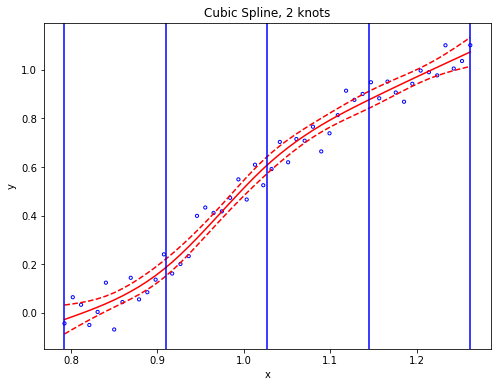

In [11]:
m_linear_fit_b.head(3)
plt.figure(figsize=(8, 6))
plt.scatter(x, y, facecolors='none', edgecolors='b', s=10);
plt.plot(x, m_linear_fit_b["mean"], color='r');
plt.plot(x, m_linear_fit_b["mean_ci_lower"], color='r', linestyle='dashed');
plt.plot(x, m_linear_fit_b["mean_ci_upper"], color='r', linestyle='dashed');
plt.axvline(x=cs_knots_b[0], color='b');
plt.axvline(x=cs_knots_b[1], color='b');
plt.axvline(x=cs_knots_b[2], color='b');
plt.axvline(x=cs_knots_b[3], color='b');
plt.axvline(x=cs_knots_b[4], color='b');
plt.title("Cubic Spline, 2 knots");
plt.xlabel("x");
plt.ylabel("y");

[c]

In [12]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr


r_base = importr('base')
r_stats = importr('stats')
r_splines = importr('splines')

In [13]:
r_ncs_knots = np.quantile(x, [0.25, 0.5, 0.75])
r_x = ro.FloatVector(x)
r_ncs_knots = ro.FloatVector(r_ncs_knots)
r_ncs_basis = r_splines.ns(r_x, knots = r_ncs_knots, intercept = True)
#print(r_base.attr(r_ncs_basis, 'knots'))  # same knots as input

r_ncs_df = pd.DataFrame(np.array(r_ncs_basis))
r_ncs_df.head(3)

,0,1,2,3,4
0,-0.267261,0.000000,-0.214286,0.642857,-0.428571
1,-0.167808,0.000091,-0.199852,0.599557,-0.399705
2,-0.069538,0.000725,-0.185495,0.556485,-0.370990


In [14]:
# estimation
r_ncs_linear = sm.OLS(list(y), r_ncs_df).fit()

# prediction and inference
r_ncs_linear_fit = r_ncs_linear.get_prediction(r_ncs_df).summary_frame()
r_ncs_linear_fit.head(3)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-0.028200,0.029615,-0.087848,0.031449,-0.155083,0.098683
1,-0.016021,0.025864,-0.068113,0.036071,-0.139532,0.107490
2,-0.003628,0.022423,-0.048789,0.041533,-0.124379,0.117123


[d]

In [15]:
#get the middle line
r_x = ro.FloatVector(x)
r_y = ro.FloatVector(y)

kwargs = {'x':r_x, 'y':r_y}
r_smooth_spline_mid = ro.r['smooth.spline'](**kwargs)
r_ss_pred_mid = np.array(ro.r['predict'](r_smooth_spline_mid, r_x).rx2('y'))
r_ss_pred_mid

array([-0.02306589, -0.01343   , -0.00386791,  0.00605059,  0.01699834,
        0.02934739,  0.04344179,  0.05999213,  0.07916194,  0.10094807,
        0.12563304,  0.15326136,  0.18354104,  0.21610023,  0.25079332,
        0.28716256,  0.3242974 ,  0.3610057 ,  0.3965577 ,  0.43077541,
        0.46364907,  0.49512452,  0.52526193,  0.55436511,  0.58255041,
        0.61008616,  0.63695672,  0.66305121,  0.68855742,  0.71354444,
        0.73816656,  0.76262798,  0.78714564,  0.8113311 ,  0.8343736 ,
        0.85552319,  0.87453327,  0.89143712,  0.90653907,  0.92048643,
        0.93391951,  0.94758957,  0.9620213 ,  0.97721212,  0.99296224,
        1.00915807,  1.025656  ,  1.04223513,  1.05903046,  1.07599972])

In [16]:
replicates = 1000

def simple_resample(n):
    return(np.random.randint(low = 0, high = n, size = n))

def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = replicates):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

In [17]:
benchmark = (r_smooth_spline_mid.rx2("lambda"))
benchmark

0.000969


In [18]:
# prediction intervals
pi = ro.r['predict'](r_ncs_linear_fit, ro.DataFrame({'x':ro.FloatVector(x)}),
                     interval = 'prediction')
pi = np.array(pi)  # [fit, lwr, upr]
pi[0:3]

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'pandas.core.frame.DataFrame'>'

In [19]:
def get_conf_int(df, lam = benchmark):
    r_y = ro.FloatVector(df[:,1])
    r_x = ro.FloatVector(df[:,0])

    kwargs = {'x':r_x, 'y':r_y, 'lambda': lam}
    r_smooth_spline = ro.r['smooth.spline'](**kwargs)
    r_ss_pred = np.array(ro.r['predict'](r_smooth_spline, r_x).rx2('y'))

    return r_ss_pred

data_array = data.loc[:, ["x", "y"]].values

r_ss_pred = pd.DataFrame(list(map(np.ravel, bootstrap(data_array, get_conf_int))))
r_ss_pred

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.509397,0.080651,0.864420,0.105227,0.558766,0.959206,0.271066,0.975690,0.409865,0.379546,...,0.584666,0.509397,0.379546,0.899616,0.883179,0.132632,0.992564,0.132632,0.843048,0.080651
1,0.637498,0.167999,1.044690,0.817631,0.014232,0.955687,0.664358,1.026185,0.023798,0.925378,...,0.014232,0.062234,0.107712,0.610502,0.910396,0.910396,0.989594,0.925378,0.817631,0.347131
2,0.987895,0.987895,0.928339,0.730726,0.051053,-0.071156,0.987895,0.335712,0.890952,0.597468,...,0.130867,0.226615,0.967593,0.646987,0.076444,0.794473,0.794473,-0.027513,0.570002,1.049776
3,1.054419,0.204464,0.749026,0.474333,0.948250,0.370924,0.698531,0.506220,0.564672,0.618993,...,0.591957,0.672373,0.591957,0.082945,0.855712,1.075529,0.039339,0.474333,0.474333,0.888162
4,0.312890,0.990854,0.063085,1.004953,0.645380,0.861061,0.645380,0.010563,0.454863,0.645380,...,-0.007171,0.080669,0.422084,0.947578,0.274852,0.238560,0.238560,0.274852,0.542427,0.781181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.085823,0.188692,1.043878,-0.007304,0.221432,0.131559,0.294042,0.435712,0.894049,0.874649,...,1.098202,-0.007304,0.331727,0.368237,0.331727,0.555937,0.066311,0.957174,1.061932,0.435712
996,0.822815,0.508390,0.911055,0.180741,0.972893,0.923889,0.508390,0.214514,0.323767,0.287037,...,0.897231,0.960371,0.716941,0.999188,0.716941,0.864436,-0.007387,0.822815,0.936122,0.844805
997,0.115883,0.743043,0.690412,0.398556,0.905982,0.221820,0.027526,1.100478,0.460876,1.011886,...,0.856210,0.945982,0.027526,0.084657,0.716315,0.329182,0.460876,0.398556,0.329182,0.799781
998,-0.022548,-0.046071,0.672908,1.086574,1.053732,0.223274,0.556431,-0.010586,0.189959,0.223274,...,1.086574,0.870233,1.053732,0.633693,0.085064,0.030710,0.728870,0.610659,0.015951,1.102404


In [41]:
import scipy.stats as stats
z = stats.norm.ppf(0.95)
#z = 0.95
#print(z)
mean =  r_ss_pred_mid #+ r_ss_pred.mean(axis=0)* 0.01
se = r_ss_pred.std(axis=0)/np.sqrt(replicates)
#print(se)
upper = mean + z * se
lower = mean - z * se

ss_bootstrap = pd.DataFrame({"mean":r_ss_pred_mid, "mean_ci_lower":lower, "mean_ci_upper":upper})
ss_bootstrap.head(3)
#print(mean)

,mean,mean_ci_lower,mean_ci_upper
0,-0.023066,-0.041564,-0.004567
1,-0.013430,-0.032577,0.005717
2,-0.003868,-0.022622,0.014886


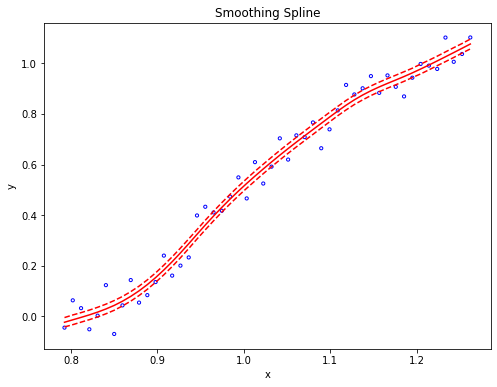

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, facecolors='none', edgecolors='b', s=10);
plt.plot(x, ss_bootstrap["mean"], color = 'r');
plt.plot(x, ss_bootstrap["mean_ci_lower"], color = 'r', linestyle = 'dashed');
plt.plot(x, ss_bootstrap["mean_ci_upper"], color = 'r', linestyle = 'dashed');
plt.title("Smoothing Spline");
plt.xlabel("x");
plt.ylabel("y");